# =============================================
# Fragility Detection (Normal / Osteopenia / Osteoporosis)
# =============================================

# Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


# Step 2: Define paths
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test"


# Step 3: Image Data Generators with Normalization & Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Step 4: Create Train and Test Generators
img_size = (224, 224)
batch_size = 32

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 5: Handle Class Imbalance (Balancing)
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

# Step 6: Define CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Step 7: Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('fragility_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

# Step 8: Plot Accuracy and Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Step 9: Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Step 10: Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)
class_labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))


# =============================================
# Fragility Detection (Normal / Osteopenia / Osteoporosis)
# Using Transfer Learning (ResNet50)
# =============================================

# Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

# Step 2: Define paths
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test"

# Step 3: Image Data Generators with Normalization & Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Step 4: Create Train and Test Generators
img_size = (224, 224)
batch_size = 32

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 5: Handle Class Imbalance (Balancing)
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

# Step 6: Define Transfer Learning Model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Step 7: Define Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('fragility_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6)

# Step 8: Train Model
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

# Step 9: Plot Accuracy and Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 10: Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

# Step 11: Confusion Matrix & Classification Report
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

# Step 12 (Optional): Fine-tuning (Unfreeze last few layers)
# Once the model stabilizes, you can fine-tune:
# for layer in base_model.layers[-20:]:
#     layer.trainable = True
# model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_gen, validation_data=test_gen, epochs=5)


In [1]:
# Fragility Detection Notebook (script version)
# EfficientNetB0 transfer learning + fine-tuning + improved augmentation
# Paths (user confirmed)
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train"
test_dir  = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test"

# --------------- Imports ---------------
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Use EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# --------------- Configs ---------------
IMG_SIZE = (224, 224)   # set 256 if GPU allows
BATCH_SIZE = 32
SEED = 42
EPOCHS = 30

# --------------- Data Generators ---------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.25,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_gen = valid_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --------------- Class weights to handle imbalance ---------------
labels = train_gen.classes
class_weights_arr = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights_arr))
print('Class weights:', class_weights)

# --------------- Build Model (EfficientNetB0) ---------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D(name='gap')(x)
# add a small head with batchnorm & dropout
x = BatchNormalization(name='bn_1')(x)
x = Dropout(0.4, name='drop_1')(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = BatchNormalization(name='bn_2')(x)
x = Dropout(0.3, name='drop_2')(x)
outputs = Dense(train_gen.num_classes, activation='softmax', name='preds')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --------------- Callbacks ---------------
checkpoint_path = 'fragility_efficientnetb0.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
]

# --------------- Train head ---------------
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=valid_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

# --------------- Evaluate after head training ---------------
val_loss, val_acc = model.evaluate(valid_gen)
print(f"After head training - val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}")

# --------------- Fine-tuning: unfreeze top layers ---------------
# Unfreeze last N layers of the base model
N = 30
for layer in base_model.layers[-N:]:
    layer.trainable = True

# recompile with lower LR
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# continue training (fine-tuning)
history_fine = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=valid_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

# --------------- Final Evaluation ---------------
test_loss, test_acc = model.evaluate(valid_gen)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# Predictions & Metrics
y_pred_probs = model.predict(valid_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = valid_gen.classes

cm = confusion_matrix(y_true, y_pred)
labels_names = list(valid_gen.class_indices.keys())

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('\nClassification Report:\n')
print(classification_report(y_true, y_pred, target_names=labels_names))

# --------------- Save final model (already checkpointed) ---------------
model.save(checkpoint_path)
print('Model saved to', checkpoint_path)

# --------------- Optional: Grad-CAM helper (uncomment to use) ---------------
# This helper provides class activation maps for interpretability.
# Requires tf 2.x
#
# import tensorflow as tf
# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     grad_model = tf.keras.models.Model([
#         model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(predictions[0])
#         class_channel = predictions[:, pred_index]
#     grads = tape.gradient(class_channel, conv_outputs)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     conv_outputs = conv_outputs[0]
#     heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
#     return heatmap.numpy()
#
# To use Grad-CAM: provide an input image array preprocessed (rescaled/ resized), then call
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='top_conv')

# --------------- End of script ---------------


Found 2388 images belonging to 3 classes.
Found 1147 images belonging to 3 classes.
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [5]:
# =============================================
# Fragility Detection (Normal / Osteopenia / Osteoporosis)
# =============================================

# Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Step 2: Define Paths
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test"

# Step 3: Data Generators (With RGB Conversion + Augmentation)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',   # ✅ Ensure RGB (3 channels)
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',   # ✅ Ensure RGB
    shuffle=False
)

# Step 4: Compute Class Weights (for imbalance handling)
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Computed Class Weights:", class_weights)

# Step 5: Build Transfer Learning Model (EfficientNetB0)
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze base model initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Step 6: Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('fragility_best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

# Step 7: Unfreeze top layers for Fine-Tuning
for layer in base_model.layers[-50:]:  # unfreeze last 50 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

# Step 8: Plot Accuracy & Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 9: Evaluate Model
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

# Step 10: Confusion Matrix & Classification Report
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))


Found 2388 images belonging to 3 classes.
Found 1147 images belonging to 3 classes.
Computed Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 1)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 224, 224, 1)       │               3 │ rescaling_1[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 1)       │               0 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             288 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, 112, 112, 32)      │               

 Total params: 4,052,834 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,048,991 (15.45 MB)

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "stem_conv" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 225, 225, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

🔄 Converting grayscale images to RGB if found...
✅ Conversion complete!
🔄 Converting grayscale images to RGB if found...
✅ Conversion complete!
Found 2388 images belonging to 3 classes.
Found 1147 images belonging to 3 classes.
📊 Computed Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, 112, 112, 32)      │               0 │ block1a_activation[0][0],  │
│                               │                           │               

 Total params: 4,383,398 (16.72 MB)

 Trainable params: 331,267 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3350 - loss: 1.3102 - val_accuracy: 0.1944 - val_loss: 1.1069 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.3258 - loss: 1.3045 - val_accuracy: 0.1944 - val_loss: 1.1088 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3513 - loss: 1.2876 - val_accuracy: 0.3958 - val_loss: 1.1053 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.3375 - loss: 1.2675 - val_accuracy: 0.4106 - val_loss: 1.1034 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3266 - loss: 1.2582 - val_accuracy: 0.4106 - val_loss: 1.0945 - learning_rate: 1.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3559 - loss: 1.2391 - val_accuracy: 0.4106 - val_loss: 1.0934 - learning_rate: 1.0000e-04
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3338 

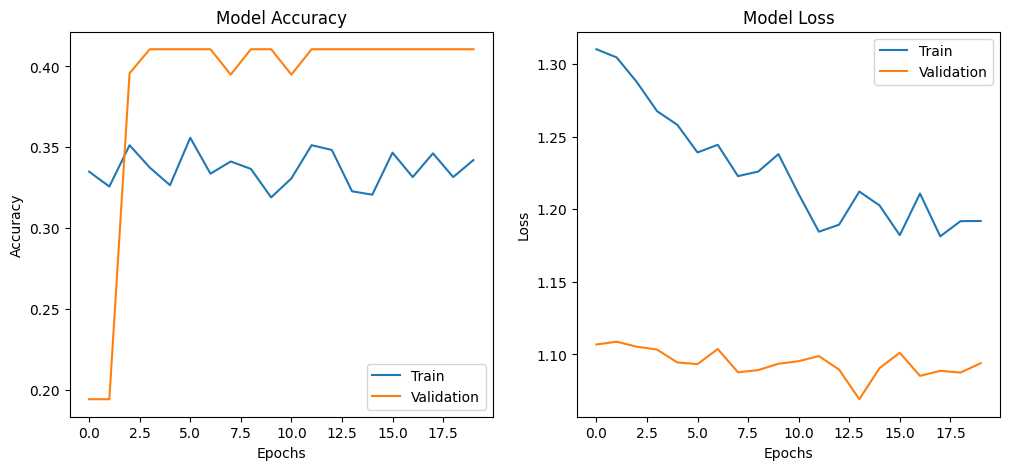

36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 952ms/step - accuracy: 0.4106 - loss: 1.0692    

✅ Test Accuracy: 41.06%
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step   


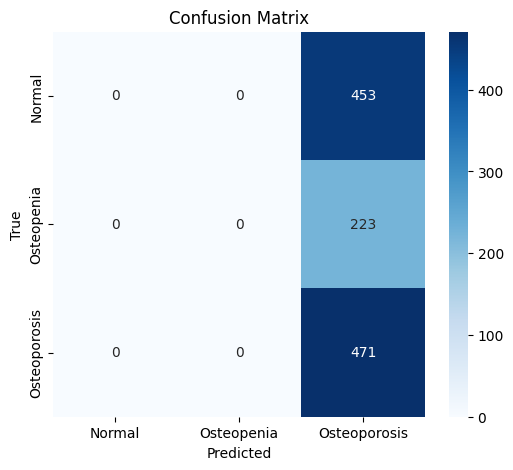


Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       453
  Osteopenia       0.00      0.00      0.00       223
Osteoporosis       0.41      1.00      0.58       471

    accuracy                           0.41      1147
   macro avg       0.14      0.33      0.19      1147
weighted avg       0.17      0.41      0.24      1147



C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [4]:
# =============================================
# =====================================================
# Fragility Detection using EfficientNetB0 (RGB Images)
# Classes: Normal / Osteopenia / Osteoporosis
# =====================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ===========================
# Step 1: Paths
# ===========================
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test"

# ===========================
# Step 2: Convert grayscale → RGB
# ===========================
def convert_to_rgb(folder):
    print("🔄 Converting grayscale images to RGB if found...")
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(subdir, file)
                img = cv2.imread(path)
                if img is not None and len(img.shape) == 2:  # grayscale image
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    cv2.imwrite(path, img_rgb)
    print("✅ Conversion complete!")

convert_to_rgb(train_dir)
convert_to_rgb(test_dir)

# ===========================
# Step 3: Image Generators
# ===========================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# ===========================
# Step 4: Handle Class Imbalance
# ===========================
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("📊 Computed Class Weights:", class_weights)

# ===========================
# Step 5: Build EfficientNetB0 Model
# ===========================
tf.keras.backend.clear_session()

from tensorflow.keras.utils import get_file
weights_path = get_file(
    'efficientnetb0_notop.h5',
    'https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5',
    cache_subdir='models'
)

base_model = EfficientNetB0(
    weights=None, 
    include_top=False, 
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.load_weights(weights_path)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

# ===========================
# Step 6: Callbacks
# ===========================
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint('fragility_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

# ===========================
# Step 7: Train Model
# ===========================
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# ===========================
# Step 8: Plot Accuracy/Loss
# ===========================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ===========================
# Step 9: Evaluate
# ===========================
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

# ===========================
# Step 10: Confusion Matrix
# ===========================
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))


🔄 Converting grayscale images to RGB if found...
✅ Conversion complete!
🔄 Converting grayscale images to RGB if found...
✅ Conversion complete!
Found 2388 images belonging to 3 classes.
Found 1147 images belonging to 3 classes.
📊 Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, 112, 112, 32)      │               0 │ block1a_activation[0][0],  │
│                               │                           │               

 Total params: 4,383,398 (16.72 MB)

 Trainable params: 331,267 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.3346 - loss: 1.3278 - val_accuracy: 0.1944 - val_loss: 1.1086 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3291 - loss: 1.2857 - val_accuracy: 0.1944 - val_loss: 1.1145 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.3111 - loss: 1.3161 - val_accuracy: 0.1944 - val_loss: 1.1212 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3373 - loss: 1.2734  
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
75/75 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3367 - loss: 1.2649 - val_accuracy: 0.1944 - val_loss: 1.1213 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3354 - loss: 1.2636 - val_accuracy: 0.1944 - val_loss: 1.1292 - learning_rate: 3.0000e-05
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.3296 - lo

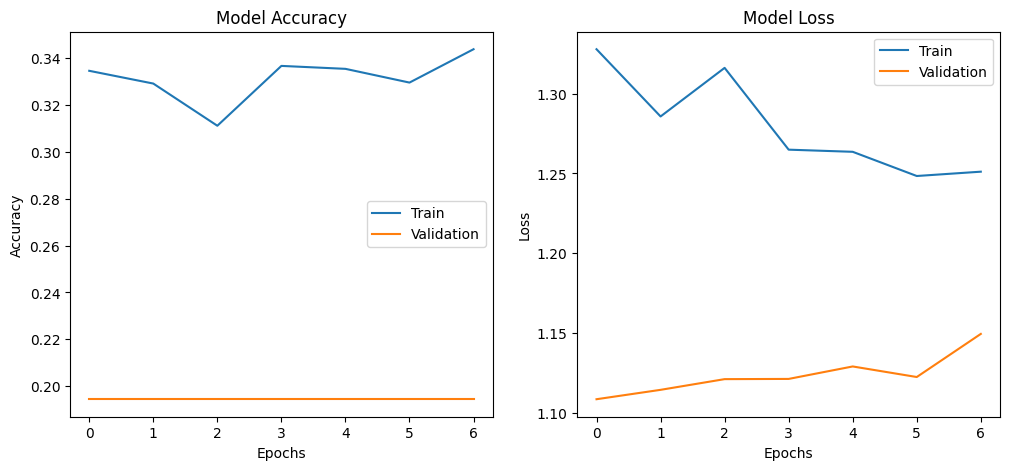

36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 967ms/step - accuracy: 0.1944 - loss: 1.1086    

✅ Test Accuracy: 19.44%
36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 972ms/step


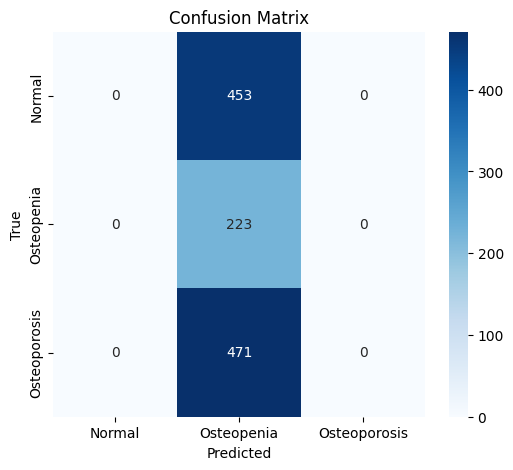


Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       453
  Osteopenia       0.19      1.00      0.33       223
Osteoporosis       0.00      0.00      0.00       471

    accuracy                           0.19      1147
   macro avg       0.06      0.33      0.11      1147
weighted avg       0.04      0.19      0.06      1147



C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [1]:
# =====================================================
# Fragility Detection using EfficientNetB0 (RGB Images)
# Classes: Normal / Osteopenia / Osteoporosis
# =====================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ===========================
# Step 1: Paths
# ===========================
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test"

# ===========================
# Step 2: Convert grayscale → RGB
# ===========================
def convert_to_rgb(folder):
    print("🔄 Converting grayscale images to RGB if found...")
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(subdir, file)
                img = cv2.imread(path)
                if img is not None and len(img.shape) == 2:  # grayscale
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    cv2.imwrite(path, img_rgb)
    print("✅ Conversion complete!")

convert_to_rgb(train_dir)
convert_to_rgb(test_dir)

# ===========================
# Step 3: Image Generators
# ===========================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# ===========================
# Step 4: Class Balancing
# ===========================
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("📊 Class Weights:", class_weights)

# ===========================
# Step 5: Build EfficientNetB0 Model
# ===========================
tf.keras.backend.clear_session()

from tensorflow.keras.utils import get_file
weights_path = get_file(
    'efficientnetb0_notop.h5',
    'https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5',
    cache_subdir='models'
)

base_model = EfficientNetB0(
    weights=None,
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.load_weights(weights_path)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ===========================
# Step 6: Callbacks (with Accuracy Threshold)
# ===========================
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=0.90):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("val_accuracy")
        if acc is not None and acc > self.threshold:
            print(f"\n🎯 Validation accuracy reached {acc:.2f}, stopping training!")
            self.model.stop_training = True

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint('fragility_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
accuracy_stop = AccuracyThresholdCallback(threshold=0.90)

# ===========================
# Step 7: Train Model
# ===========================
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr, accuracy_stop]
)

# ===========================
# Step 8: Plot Accuracy/Loss
# ===========================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ===========================
# Step 9: Evaluation
# ===========================
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

# ===========================
# Step 10: Confusion Matrix & Report
# ===========================
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))


🔄 Converting and enhancing images in C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train ...
✅ Conversion + Enhancement done for C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train
🔄 Converting and enhancing images in C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test ...
✅ Conversion + Enhancement done for C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test
Found 2388 images belonging to 3 classes.
Found 1147 images belonging to 3 classes.
📊 Computed Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,300,675 (27.85 MB)

 Trainable params: 263,171 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3300 - loss: 1.9249  

75/75 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.3631 - loss: 1.6778 - val_accuracy: 0.5292 - val_loss: 0.9618 - learning_rate: 1.0000e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4367 - loss: 1.3648  

75/75 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.4510 - loss: 1.3249 - val_accuracy: 0.6713 - val_loss: 0.8158 - learning_rate: 9.9384e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5018 - loss: 1.1525  

75/75 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.5075 - loss: 1.1316 - val_accuracy: 0.6905 - val_loss: 0.7619 - learning_rate: 9.7553e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5245 - loss: 1.0742  

75/75 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.5402 - loss: 1.0474 - val_accuracy: 0.6931 - val_loss: 0.7493 - learning_rate: 9.4550e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5605 - loss: 1.0125  

75/75 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.5544 - loss: 1.0193 - val_accuracy: 0.6983 - val_loss: 0.7390 - learning_rate: 9.0451e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.5762 - loss: 0.9561 - val_accuracy: 0.6983 - val_loss: 0.7369 - learning_rate: 8.5355e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.5917 - loss: 0.9227 - val_accuracy: 0.6983 - val_loss: 0.7066 - learning_rate: 7.9389e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5792 - loss: 0.9323  

75/75 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.5833 - loss: 0.9302 - val_accuracy: 0.7071 - val_loss: 0.7098 - learning_rate: 7.2700e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.5838 - loss: 0.9164 - val_accuracy: 0.7044 - val_loss: 0.7056 - learning_rate: 6.5451e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.5976 - loss: 0.9085 - val_accuracy: 0.7053 - val_loss: 0.7090 - learning_rate: 5.7822e-05
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.6189 - loss: 0.8622 - val_accuracy: 0.6861 - val_loss: 0.6874 - learning_rate: 1.0000e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.6583 - loss: 0.7781 - val_accuracy: 0.6748 - val_loss: 0.6654 - learning_rate: 9.9384e-05
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6915 - loss: 0.7024  

75/75 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.6884 - loss: 0.7065 - val_accuracy: 0.7175 - val_loss: 0.6414 - learning_rate: 9.7553e-05
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.6834 - loss: 0.7154 - val_accuracy: 0.7105 - val_loss: 0.6460 - learning_rate: 9.4550e-05
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.7073 - loss: 0.6715 - val_accuracy: 0.7027 - val_loss: 0.6296 - learning_rate: 9.0451e-05
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.7198 - loss: 0.6443 - val_accuracy: 0.7071 - val_loss: 0.6420 - learning_rate: 8.5355e-05
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7172 - loss: 0.6255  

75/75 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.7098 - loss: 0.6427 - val_accuracy: 0.7271 - val_loss: 0.6095 - learning_rate: 7.9389e-05
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7106 - loss: 0.6360  

75/75 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7081 - loss: 0.6361 - val_accuracy: 0.7315 - val_loss: 0.6034 - learning_rate: 7.2700e-05
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7194 - loss: 0.6083 - val_accuracy: 0.7158 - val_loss: 0.6031 - learning_rate: 6.5451e-05
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.7270 - loss: 0.5964 - val_accuracy: 0.7219 - val_loss: 0.5992 - learning_rate: 5.7822e-05
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7526 - loss: 0.5762  

75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.7454 - loss: 0.5843 - val_accuracy: 0.7411 - val_loss: 0.5886 - learning_rate: 5.0000e-05
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.7513 - loss: 0.5745 - val_accuracy: 0.7271 - val_loss: 0.5894 - learning_rate: 4.2178e-05
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.7475 - loss: 0.5856 - val_accuracy: 0.7332 - val_loss: 0.5824 - learning_rate: 3.4549e-05
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.7621 - loss: 0.5528 - val_accuracy: 0.7402 - val_loss: 0.5810 - learning_rate: 2.7300e-05
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7454 - loss: 0.5677 - val_accuracy: 0.7297 - val_loss: 0.5847 - learning_rate: 2.0611e-05
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.7370 - loss: 0.5716 - val_accuracy: 0.7411 - val_loss: 0.5811 - learning_rate: 1.4645e-05
Epoch 17/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7578 - loss:

75/75 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.7605 - loss: 0.5485 - val_accuracy: 0.7419 - val_loss: 0.5791 - learning_rate: 9.5492e-06
Epoch 18/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.7630 - loss: 0.5533 - val_accuracy: 0.7419 - val_loss: 0.5789 - learning_rate: 5.4497e-06
Epoch 19/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.7517 - loss: 0.5559 - val_accuracy: 0.7376 - val_loss: 0.5791 - learning_rate: 2.4472e-06
Epoch 20/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.7668 - loss: 0.5520 - val_accuracy: 0.7411 - val_loss: 0.5779 - learning_rate: 6.1558e-07


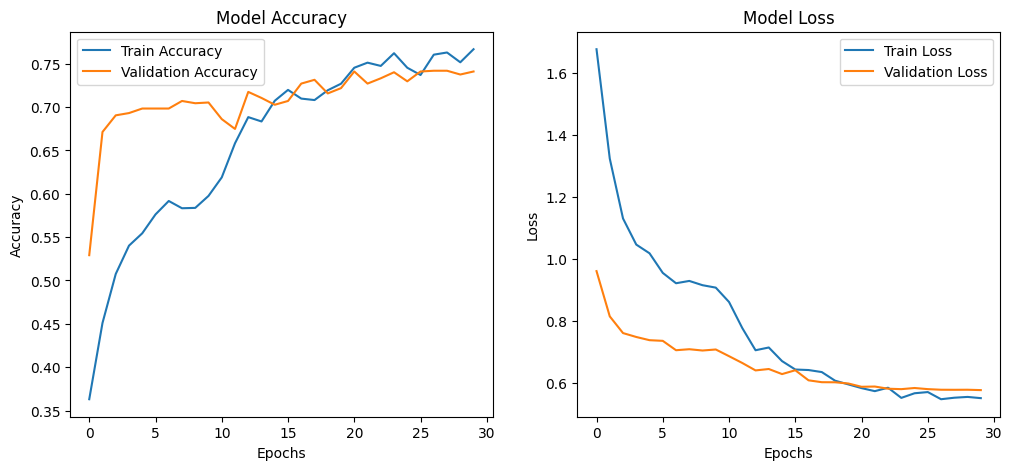

36/36 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7411 - loss: 0.5779 

✅ Final Test Accuracy: 74.11%
36/36 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step 


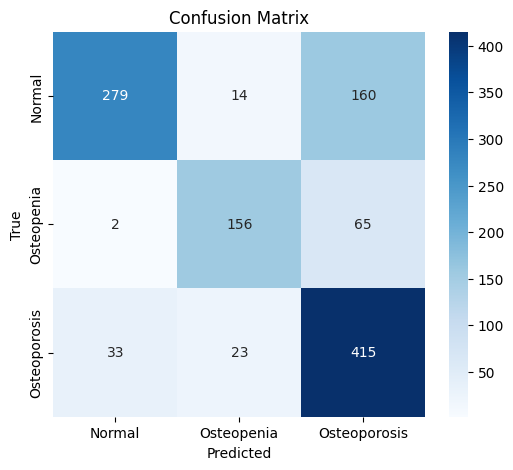


📋 Classification Report:
               precision    recall  f1-score   support

      Normal       0.89      0.62      0.73       453
  Osteopenia       0.81      0.70      0.75       223
Osteoporosis       0.65      0.88      0.75       471

    accuracy                           0.74      1147
   macro avg       0.78      0.73      0.74      1147
weighted avg       0.77      0.74      0.74      1147



In [4]:
# =============================================
# Fragility Detection (Normal / Osteopenia / Osteoporosis)
# Optimized Full Pipeline - DenseNet121 + CLAHE + Fine-Tuning
# =============================================

# Step 1: Import Libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# =============================================================
# Step 2: Define Paths
# =============================================================
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test"

# =============================================================
# Step 3: Convert Grayscale → RGB and Apply CLAHE Enhancement
# =============================================================
def convert_gray_to_rgb_and_clahe(folder):
    print(f"🔄 Converting and enhancing images in {folder} ...")
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(subdir, file)
                img = cv2.imread(path)
                if img is None:
                    continue
                # Convert to RGB if grayscale
                if len(img.shape) == 2 or img.shape[2] == 1:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                # Apply CLAHE for better bone detail
                img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
                enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
                cv2.imwrite(path, enhanced)
    print(f"✅ Conversion + Enhancement done for {folder}")

convert_gray_to_rgb_and_clahe(train_dir)
convert_gray_to_rgb_and_clahe(test_dir)

# =============================================================
# Step 4: Data Generators with Strong Augmentation
# =============================================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)   

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# =============================================================
# Step 5: Handle Class Imbalance
# =============================================================
labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("📊 Computed Class Weights:", class_weights)

# =============================================================
# Step 6: Build DenseNet121 Model
# =============================================================
tf.keras.backend.clear_session()
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# =============================================================
# Step 7: Define Custom Callbacks
# =============================================================

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras.backend as K
import math

# =============================================================
# Step 7: Callbacks
# =============================================================
save_model_path = r"C:\Users\lenovo\Desktop\FractureNet+\Models"

# Create directory if not exists
os.makedirs(save_model_path, exist_ok=True)

# Learning rate scheduler (cosine decay)
def cosine_decay(epoch, lr):
    initial_lr = 1e-4
    epochs = 20
    lr = initial_lr * (0.5 * (1 + math.cos(math.pi * epoch / epochs)))
    return float(lr)  # ✅ ensure Python float, not numpy type

# Accuracy threshold callback
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=0.90):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("val_accuracy")
        if acc and acc > self.threshold:
            print(f"\n✅ Accuracy {acc:.2f} > {self.threshold*100}% — stopping training early!")
            self.model.stop_training = True

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=os.path.join(save_model_path,'fragility_best_densenet.h5'), save_best_only=True, monitor='val_accuracy', mode='max')

lr_scheduler = LearningRateScheduler(cosine_decay)
accuracy_stop = AccuracyThresholdCallback(threshold=0.90)

# =============================================================
# Step 8: Train (Phase 1 - Freeze Base)
# =============================================================
history_1 = model.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, lr_scheduler, accuracy_stop]
)

# =============================================================
# Step 9: Fine-Tune (Unfreeze last 30 layers)
# =============================================================
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_2 = model.fit(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, lr_scheduler, accuracy_stop]
)

# Merge histories
history = {
    'accuracy': history_1.history['accuracy'] + history_2.history['accuracy'],
    'val_accuracy': history_1.history['val_accuracy'] + history_2.history['val_accuracy'],
    'loss': history_1.history['loss'] + history_2.history['loss'],
    'val_loss': history_1.history['val_loss'] + history_2.history['val_loss']
}


# =============================================================
# Step 10: Evaluation & Visualization
# =============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.show()

# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Final Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

print("\n📋 Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=labels))


🔄 Converting and enhancing images in C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train ...
✅ Conversion + Enhancement done for C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train
🔄 Converting and enhancing images in C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test ...
✅ Conversion + Enhancement done for C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test
Found 2388 images belonging to 3 classes.
Found 1147 images belonging to 3 classes.
📊 Computed Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,300,675 (27.85 MB)

 Trainable params: 263,171 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3636 - loss: 1.5866  

75/75 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.3999 - loss: 1.4709 - val_accuracy: 0.5990 - val_loss: 0.8908 - learning_rate: 1.0000e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4419 - loss: 1.2906  

75/75 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.4711 - loss: 1.2255 - val_accuracy: 0.6539 - val_loss: 0.8405 - learning_rate: 9.9384e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5126 - loss: 1.1146  

75/75 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.5159 - loss: 1.0955 - val_accuracy: 0.6861 - val_loss: 0.7448 - learning_rate: 9.7553e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5515 - loss: 1.0429  

75/75 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.5456 - loss: 1.0179 - val_accuracy: 0.6922 - val_loss: 0.7415 - learning_rate: 9.4550e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.5745 - loss: 0.9789 - val_accuracy: 0.6827 - val_loss: 0.7126 - learning_rate: 9.0451e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.5959 - loss: 0.9221 - val_accuracy: 0.6905 - val_loss: 0.7259 - learning_rate: 8.5355e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.5946 - loss: 0.9168 - val_accuracy: 0.6800 - val_loss: 0.6998 - learning_rate: 7.9389e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5811 - loss: 0.9226  

75/75 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.5900 - loss: 0.9172 - val_accuracy: 0.6957 - val_loss: 0.7026 - learning_rate: 7.2700e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.6173 - loss: 0.8620 - val_accuracy: 0.6835 - val_loss: 0.7000 - learning_rate: 6.5451e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.6097 - loss: 0.8670 - val_accuracy: 0.6670 - val_loss: 0.7005 - learning_rate: 5.7822e-05
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.6173 - loss: 0.8544 - val_accuracy: 0.6765 - val_loss: 0.6696 - learning_rate: 1.0000e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6682 - loss: 0.7282  

75/75 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.6650 - loss: 0.7344 - val_accuracy: 0.7201 - val_loss: 0.6286 - learning_rate: 9.9384e-05
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7105 - loss: 0.6743  

75/75 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.7035 - loss: 0.6796 - val_accuracy: 0.7332 - val_loss: 0.5974 - learning_rate: 9.7553e-05
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.7207 - loss: 0.6434 - val_accuracy: 0.7289 - val_loss: 0.5899 - learning_rate: 9.4550e-05
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.7249 - loss: 0.6519 - val_accuracy: 0.7297 - val_loss: 0.5772 - learning_rate: 9.0451e-05
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.7295 - loss: 0.6244 - val_accuracy: 0.7271 - val_loss: 0.5781 - learning_rate: 8.5355e-05
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7312 - loss: 0.5959  

75/75 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.7420 - loss: 0.5933 - val_accuracy: 0.7480 - val_loss: 0.5752 - learning_rate: 7.9389e-05
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7458 - loss: 0.5629  

75/75 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.7433 - loss: 0.5769 - val_accuracy: 0.7602 - val_loss: 0.5585 - learning_rate: 7.2700e-05
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.7458 - loss: 0.5656 - val_accuracy: 0.7524 - val_loss: 0.5459 - learning_rate: 6.5451e-05
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.7546 - loss: 0.5685 - val_accuracy: 0.7498 - val_loss: 0.5408 - learning_rate: 5.7822e-05
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.7680 - loss: 0.5415 - val_accuracy: 0.7585 - val_loss: 0.5347 - learning_rate: 5.0000e-05
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7681 - loss: 0.5328  

75/75 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.7626 - loss: 0.5396 - val_accuracy: 0.7637 - val_loss: 0.5254 - learning_rate: 4.2178e-05
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7632 - loss: 0.5198  

75/75 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.7751 - loss: 0.5135 - val_accuracy: 0.7742 - val_loss: 0.5226 - learning_rate: 3.4549e-05
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7823 - loss: 0.5120  

75/75 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.7668 - loss: 0.5344 - val_accuracy: 0.7759 - val_loss: 0.5204 - learning_rate: 2.7300e-05
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.7613 - loss: 0.5238 - val_accuracy: 0.7724 - val_loss: 0.5164 - learning_rate: 2.0611e-05
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.7772 - loss: 0.5127 - val_accuracy: 0.7751 - val_loss: 0.5135 - learning_rate: 1.4645e-05
Epoch 17/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7854 - loss: 0.5299  

75/75 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.7852 - loss: 0.5222 - val_accuracy: 0.7777 - val_loss: 0.5122 - learning_rate: 9.5492e-06
Epoch 18/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.7806 - loss: 0.5162 - val_accuracy: 0.7777 - val_loss: 0.5105 - learning_rate: 5.4497e-06
Epoch 19/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7885 - loss: 0.5004  

75/75 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.7785 - loss: 0.5065 - val_accuracy: 0.7794 - val_loss: 0.5103 - learning_rate: 2.4472e-06
Epoch 20/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.7764 - loss: 0.5107 - val_accuracy: 0.7777 - val_loss: 0.5104 - learning_rate: 6.1558e-07


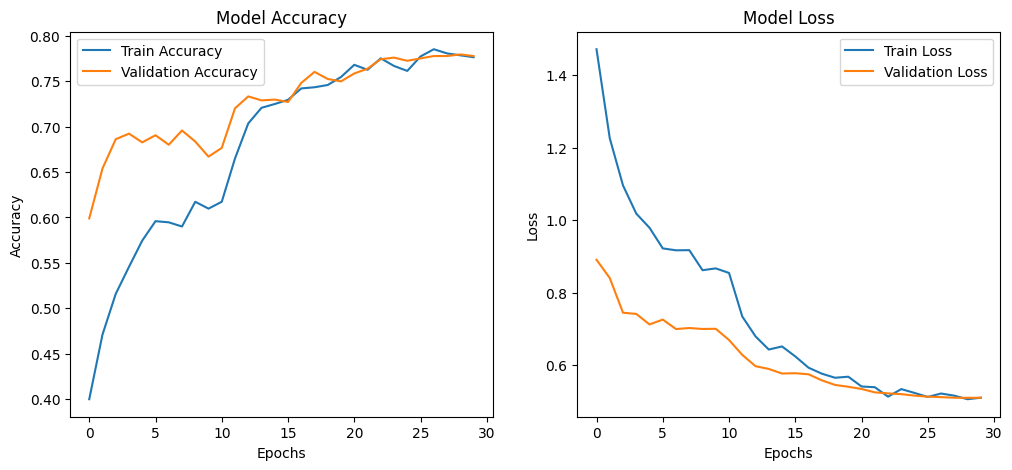

36/36 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7794 - loss: 0.5103 

✅ Final Test Accuracy: 77.94%
36/36 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step 


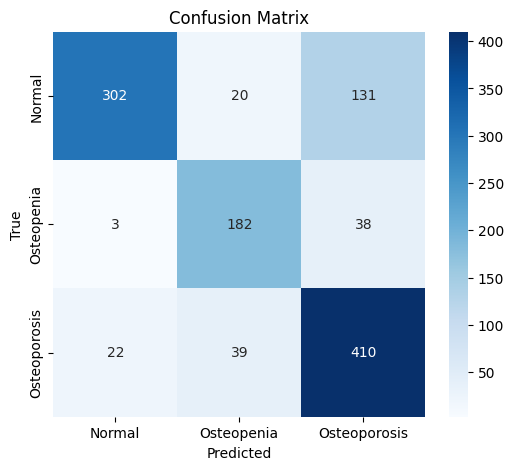


📋 Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.67      0.77       453
  Osteopenia       0.76      0.82      0.78       223
Osteoporosis       0.71      0.87      0.78       471

    accuracy                           0.78      1147
   macro avg       0.80      0.78      0.78      1147
weighted avg       0.80      0.78      0.78      1147



In [1]:
# =============================================
# Fragility Detection (Normal / Osteopenia / Osteoporosis)
# Optimized Full Pipeline - DenseNet121 + CLAHE + Fine-Tuning
# =============================================

# Step 1: Import Libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# =============================================================
# Step 2: Define Paths
# =============================================================
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\test"

# =============================================================
# Step 3: Convert Grayscale → RGB and Apply CLAHE Enhancement
# =============================================================
def convert_gray_to_rgb_and_clahe(folder):
    print(f"🔄 Converting and enhancing images in {folder} ...")
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(subdir, file)
                img = cv2.imread(path)
                if img is None:
                    continue
                # Convert to RGB if grayscale
                if len(img.shape) == 2 or img.shape[2] == 1:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                # Apply CLAHE for better bone detail
                img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
                enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
                cv2.imwrite(path, enhanced)
    print(f"✅ Conversion + Enhancement done for {folder}")

convert_gray_to_rgb_and_clahe(train_dir)
convert_gray_to_rgb_and_clahe(test_dir)

# =============================================================
# Step 4: Data Generators with Strong Augmentation
# =============================================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)   

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# =============================================================
# Step 5: Handle Class Imbalance
# =============================================================
labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("📊 Computed Class Weights:", class_weights)

# =============================================================
# Step 6: Build DenseNet121 Model
# =============================================================
tf.keras.backend.clear_session()
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
   layer.trainable = False
#````````````````for layer in base_model.layers[-60:]:
 #   layer.trainable = True


x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Multiply

def se_block(input_tensor, ratio=16):
    channel = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channel // ratio, activation='relu')(se)
    se = Dense(channel, activation='sigmoid')(se)
    se = Multiply()([input_tensor, Reshape((1,1,channel))(se)])
    return se

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# =============================================================
# Step 7: Define Custom Callbacks
# =============================================================

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras.backend as K
import math

# =============================================================
# Step 7: Callbacks
# =============================================================
save_model_path = r"C:\Users\lenovo\Desktop\FractureNet+\Models"

# Create directory if not exists
os.makedirs(save_model_path, exist_ok=True)

# Learning rate scheduler (cosine decay)
def cosine_decay(epoch, lr):
    initial_lr = 1e-4
    epochs = 20
    lr = initial_lr * (0.5 * (1 + math.cos(math.pi * epoch / epochs)))
    return float(lr)  # ✅ ensure Python float, not numpy type

# Accuracy threshold callback
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=0.90):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("val_accuracy")
        if acc and acc > self.threshold:
            print(f"\n✅ Accuracy {acc:.2f} > {self.threshold*100}% — stopping training early!")
            self.model.stop_training = True

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=os.path.join(save_model_path,'fragility_best_densenet.h5'), save_best_only=True, monitor='val_accuracy', mode='max')

lr_scheduler = LearningRateScheduler(cosine_decay)
accuracy_stop = AccuracyThresholdCallback(threshold=0.90)

# =============================================================
# Step 8: Train (Phase 1 - Freeze Base)
# =============================================================
history_1 = model.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, lr_scheduler, accuracy_stop]
)

# =============================================================
# Step 9: Fine-Tune (Unfreeze last 30 layers)
# =============================================================

for layer in base_model.layers[-60:]:
    layer.trainable = True
    
    

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_2 = model.fit(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, lr_scheduler, accuracy_stop]
)

# Merge histories
history = {
    'accuracy': history_1.history['accuracy'] + history_2.history['accuracy'],
    'val_accuracy': history_1.history['val_accuracy'] + history_2.history['val_accuracy'],
    'loss': history_1.history['loss'] + history_2.history['loss'],
    'val_loss': history_1.history['val_loss'] + history_2.history['val_loss']
}


# =============================================================
# Step 10: Evaluation & Visualization
# =============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.show()

# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Final Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

print("\n📋 Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=labels))


In [1]:
print("Class indices:", train_gen.class_indices)


NameError: name 'train_gen' is not defined

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\FragilityLevelDetection\train"

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

print("Class indices:", train_gen.class_indices)


Found 2388 images belonging to 3 classes.
Class indices: {'Normal': 0, 'Osteopenia': 1, 'Osteoporosis': 2}
